In [30]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import string
%matplotlib inline

import spacy
nlp = spacy.load("en_core_web_sm")

import nltk
from nltk.tokenize import sent_tokenize
from nltk import pos_tag, word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from textblob import TextBlob
from textblob import Word

In [31]:
s = "Apple is looking at buying U.K. startup for $1 billion"

In [32]:
doc = nlp(s)
for token in doc:
    print(token.text, token.lemma_, token.pos_, token.tag_, token.dep_,
            token.shape_, token.is_alpha, token.is_stop)

Apple Apple PROPN NNP nsubj Xxxxx True False
is be AUX VBZ aux xx True True
looking look VERB VBG ROOT xxxx True False
at at ADP IN prep xx True True
buying buy VERB VBG pcomp xxxx True False
U.K. U.K. PROPN NNP dobj X.X. False False
startup startup VERB VBD dep xxxx True False
for for ADP IN prep xxx True True
$ $ SYM $ quantmod $ False False
1 1 NUM CD compound d False False
billion billion NUM CD pobj xxxx True False


In [33]:
tokenized_sent = sent_tokenize(s)

[nltk.pos_tag(nltk.word_tokenize(word)) for word in tokenized_sent]

[[('Apple', 'NNP'),
  ('is', 'VBZ'),
  ('looking', 'VBG'),
  ('at', 'IN'),
  ('buying', 'VBG'),
  ('U.K.', 'NNP'),
  ('startup', 'NN'),
  ('for', 'IN'),
  ('$', '$'),
  ('1', 'CD'),
  ('billion', 'CD')]]

In [34]:
doc = nlp("Autonomous cars shift insurance liability toward auto manufacturers")
for chunk in doc.noun_chunks:
    print(chunk.text, chunk.root.text, chunk.root.dep_,
            chunk.root.head.text)

Autonomous cars cars nsubj shift
insurance liability liability dobj shift
auto manufacturers manufacturers pobj toward


In [35]:
df = pd.read_csv("ClothingReviews.csv")
df.head()

,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Department Name,Class Name
0,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Intimate,Intimates
1,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,Dresses,Dresses
2,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,Dresses,Dresses
3,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,Bottoms,Pants
4,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,Tops,Blouses


In [36]:
df.dropna(subset=['Department Name', 'Class Name', 'Review Text'], inplace=True)

In [37]:
df['Title'].fillna('', inplace=True)

In [38]:
df['Text'] = df['Title'] + ' ' + df['Review Text']

In [39]:
df.drop(columns=['Title', 'Review Text'], inplace=True)

In [40]:
# Add column 'text_len' that counts the length for the derived field
df['text_len'] = df.apply(lambda row: len(row['Text']), axis = 1)

## Text Cleaning

For **Parts** of our analysis, the text needs to have some basic transformation for our models to work propertly.  These are as follows:

1. **Lower**: Convert all characters to lowercase
1. **Remove Punctuation**: In most cases, punctuation doesn't help NLP and ML models and can be removed.
1. **Stop Word Removal**: Stop words generally don't add context to analysis (unless the length of text is very short (`100` - `200` characters) and can be removed.
1. **Lemmatization**: Words will be reduced to there *Lemma* or root.  This will greatly improve the accuracy of the analysis since words like `simming` and `swimmer` will be reduced to `swim`.

**Note**: The orginal text will be preserved for other analysis.

In [41]:
df['Text'][2]

'Some major design flaws I had such high hopes for this dress and really wanted it to work for me. i initially ordered the petite small (my usual size) but i found this to be outrageously small. so small in fact that i could not zip it up! i reordered it in petite medium, which was just ok. overall, the top half was comfortable and fit nicely, but the bottom half had a very tight under layer and several somewhat cheap (net) over layers. imo, a major design flaw was the net over layer sewn directly into the zipper - it c'

In [42]:
def process_string(text, stem="None"):
    
    final_string = ""
    
    text = text.lower()
    
    translator = str.maketrans('', '', string.punctuation)
    text = text.translate(translator)

    text = text.split()
    useless_words = nltk.corpus.stopwords.words("english") + list(string.punctuation)
    useless_words = useless_words + ['.', ',', '!', "'"]
    text_filtered = [word for word in text if not word in useless_words]
    
    if stem == 'Stem':
        stemmer = PorterStemmer() 
        text_stemmed = [stemmer.stem(y) for y in text_filtered]
    elif stem == 'Lem':
        lem = WordNetLemmatizer()
        text_stemmed = [lem.lemmatize(y) for y in text_filtered]
    else:
        text_stemmed = text_filtered
    
    for word in text_stemmed:
        final_string += word + " "
    
    return final_string

In [43]:
df['Text_Processed'] = df['Text'].apply(lambda x: process_string(x, stem='Lem'))

In [44]:
df['Text_Processed'][2]

'major design flaw high hope dress really wanted work initially ordered petite small usual size found outrageously small small fact could zip reordered petite medium ok overall top half comfortable fit nicely bottom half tight layer several somewhat cheap net layer imo major design flaw net layer sewn directly zipper c '

# Part-of-speech Tagging

In this portion of the analysis, we will use a method known as Part of Speech tagging or POS.  This method uses a lexicon-based lookup to identify what parts of speech words are, such as Nouns, Verbs, Adjectives, and Adverbs.  By utilizing these, we can perform various analysis such as the following:

- Word counts for different parts of speech to start giving us an overview of the most common parts of language used.
- Identify nouns used to tag products (e.g., dress, jacket, bottom, etc.).  This will give us a different look at the popularity of items vs. simply counting categories.
- Finally, we'll identify the top adjectives and adverbs for positive vs. negative reviews, telling us what words are used in each sentiment to describe the products.

In [45]:
# Tokenize the words
df['Text_Tok'] = df['Text_Processed'].apply(word_tokenize)

In [ ]:
def parse_text(x):
    '''using TextBlob, get the full parsed results (POS, etc)'''
    blob = TextBlob(x)
    p = blob.parse()
    p = re.sub(r'^\w+/', '',p)
    return p.split('/')

In [ ]:
def build_pos(x):
    '''pass a DataFrame column with tokenized text and return a DF of the Words'''
    all_words = []
    for l in x:
        all_words = all_words + l
        
    df = pd.DataFrame(all_words)
    df.columns = ['Word']
    
    # Add a column for the POS
    df['Parse'] = df['Word'].apply(lambda x: parse_text(x))
    
    # Expned the extracted list of POS tags into their own columns, and concat that back to the orig DF
    # https://chrisalbon.com/python/data_wrangling/pandas_expand_cells_containing_lists/
    par = pd.DataFrame(df['Parse'].to_list(), columns=['P1','P2', 'P3', 'P4'])
    df = pd.concat([df[:], par[:]], axis=1)
    df.drop(columns=['Parse'], inplace=True)

    return df

In [19]:
df_words = build_pos(df['Text_Tok'])

In [20]:
df_words.sample(10)

,Word,P1,P2,P3,P4
385541,pant,NN,B-NP,O,None
72410,fabric,NN,B-NP,O,None
641939,sleeve,NN,B-NP,O,None
226600,red,JJ,B-ADJP,O,None
410330,wear,VB,B-VP,O,None
355282,16,CD,O,O,None
418529,vibe,NN,B-NP,O,None
75019,made,VBN,B-VP,O,None
578277,structured,VBN,B-VP,O,None
39329,one,CD,O,O,None


**Notes:** Rather than using the much simpler approach of the POS with the TextBlog `tags` function[1], We used the `parse` function since it provides more verbose labeling text.

The attempt here was to discover if there was a better way to identify nouns that would represent product features vs. other nouns.  Unfortunately, this didn't end up providing the detail needed. More information on this is presented below.

## Word Counts for Different Parts of Speech

In [21]:
df_top_pos = df_words.groupby('P1')['P1'].count().\
    reset_index(name='count').sort_values(['count'],ascending=False).head(15)

In [22]:
df_top_pos

,P1,count
10,NN,269443
6,JJ,166550
20,VB,65338
16,RB,54957
21,VBD,37821
23,VBN,23677
1,CD,19370
5,IN,17499
22,VBG,16843
24,VBP,13960


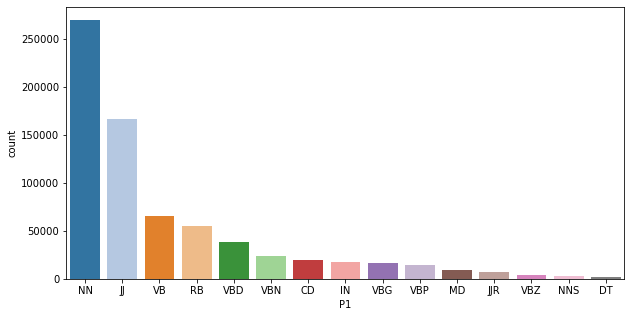

In [23]:
plt.figure(figsize=(10,5))
sns.barplot(data =df_top_pos, x='P1', y='count', palette="tab20");

## Identify Top Product Nouns

In [24]:
df_nn = df_words[df_words['P1'] == 'NN'].copy()

In [25]:
df_nn.groupby('Word')['Word'].count().reset_index(name='count').\
    sort_values(['count'], ascending=False).head(10)

,Word,count
2994,dress,12970
5449,love,10816
8332,size,9573
2151,color,7357
3371,fabric,5127
9078,sweater,3112
8139,shirt,3099
1219,bit,2947
5633,material,2922
4851,jean,2850


**Notes**:  When inspecting `nouns` only, there is a mix of different types of words displayed, and some we can see are not tagged in such a way that seems to make sense with this dataset.  For example, `love` is tagged as a noun, but it's probably an adjective.  `bit` is probably referring to an adjective as well but is showing as a noun.

We can inspect these words directly to see if there is a difference in their POS tags.

In [26]:
print(TextBlob('dress').parse())
print(TextBlob('love').parse())
print(TextBlob('bit').parse())

dress/NN/B-NP/O
love/NN/B-NP/O
bit/NN/B-NP/O


**Observations:**  When we try to use the Part of Speech (POS) tagging, there isn't a distinction between Nouns.  Each of these has the same POS sequence. 

We can use the Class name to determine clothing nouns to use.  

In [27]:
# Extract a list of all the unique class names
noun_types = list(df['Class Name'].unique())

# The words from the categories need to be lemmatized.
lem = WordNetLemmatizer()
for i in range(len(noun_types)):
    noun_types[i] = lem.lemmatize(noun_types[i].lower())
noun_types

['intimate',
 'dress',
 'pant',
 'blouse',
 'knit',
 'outerwear',
 'lounge',
 'sweater',
 'skirt',
 'fine gauge',
 'sleep',
 'jacket',
 'swim',
 'trend',
 'jean',
 'legwear',
 'short',
 'layering',
 'casual bottoms',
 'chemise']

In [28]:
# Extract all the text into a huge string and use Text Blobs to get a Dictionary out with counts
all_text = ' '.join(df['Text_Processed'])
all_text_blob = TextBlob(all_text)
all_text_dict = all_text_blob.word_counts

# Turn the dictionary into a Dataframe.  Filter by the word list and then sort for plotting.
df_dict = pd.DataFrame(list(all_text_dict.items()),columns = ['Word','Count']) 
df_products = df_dict[df_dict.Word.isin(noun_types)]
df_products.sort_values(by=['Count'], inplace=True, ascending=False)
df_products

/Users/brianroepke/miniforge3/envs/POS/lib/python3.9/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


,Word,Count
6,dress,12970
455,sweater,3112
362,jean,2850
460,short,2595
104,skirt,2480
154,pant,2366
512,jacket,1477
340,blouse,1188
506,knit,485
492,layering,258


**Observations**: Based on the top outputs, we can see that `dresses` are the largest mentioned product line at a rate of `4x` the second, `sweaters`.

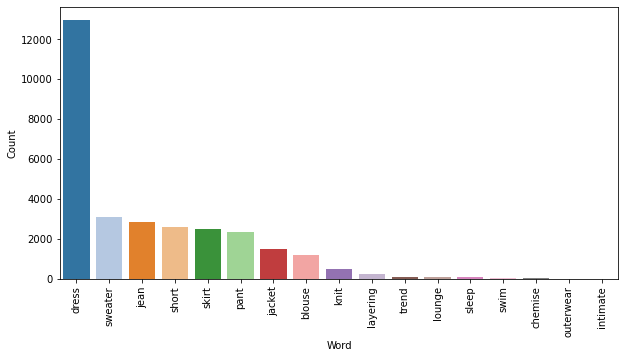

In [29]:
plt.figure(figsize=(10,5))
ax = sns.barplot(x='Word', y='Count', data=df_products, palette="tab20", dodge=False)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90);